<img src="./images/titanic_orphans.jpg" data-canonical-src="./images/titanic_orphans.jpg" width="400" height="600" />

<center><b>The Titanic Orphans: Two brothers put on last lifeboat by father.</b></center>

## 1 Introduction

This notebook will also focus on applying R programming language upon the Titanic dataset.

There are three parts to my script as follows:

1. Feature engineering: Phase 1: Adding New Features
1. Feature engineering: Phase 2: Missing Values
1. Prediction using randomForest

### 1.1 Load Libraries

In [98]:
# Load packages
library('ggplot2', warn.conflicts = FALSE) # visualization
library('ggthemes', warn.conflicts = FALSE) # visualization
library('scales', warn.conflicts = FALSE) # visualization
library('dplyr', warn.conflicts = FALSE) # data manipulation
library('randomForest', warn.conflicts = FALSE, quietly = TRUE) # classification algorithm
library('ggraph', warn.conflicts = FALSE) # visualization
library('igraph', warn.conflicts = FALSE) # visualization
library('lattice', warn.conflicts = FALSE) # visualization
library('mice', warn.conflicts = FALSE) # imputation
library('VIM', warn.conflicts = FALSE) # imputation

### 1.2 Load Titanic Passenger Data

Now that our packages are loaded, let’s read in and take a peek at the data.

In [64]:
data_titanic <- read.csv('./../datasets/titanic_passengers_wikipedia.csv', stringsAsFactors = F)
str(data_titanic)

'data.frame':	1309 obs. of  14 variables:
 $ Pclass   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Survived : int  1 1 0 0 0 1 1 0 1 0 ...
 $ Name     : chr  "Allen, Miss. Elisabeth Walton" "Allison, Master. Hudson Trevor" "Allison, Miss. Helen Loraine" "Allison, Mr. Hudson Joshua Creighton" ...
 $ Sex      : chr  "female" "male" "female" "male" ...
 $ Age      : num  29 0.917 2 30 25 ...
 $ SibSp    : int  0 1 1 1 1 0 1 0 2 0 ...
 $ Parch    : int  0 2 2 2 2 0 0 0 0 0 ...
 $ Ticket   : chr  "24160" "113781" "113781" "113781" ...
 $ Fare     : num  211 152 152 152 152 ...
 $ Cabin    : chr  "B5" "C22 C26" "C22 C26" "C22 C26" ...
 $ Embarked : chr  "S" "S" "S" "S" ...
 $ Boat     : chr  "2" "11" "" "" ...
 $ Body     : int  NA NA NA 135 NA NA NA NA NA 22 ...
 $ Home.Dest: chr  "St Louis, MO" "Montreal, PQ / Chesterville, ON" "Montreal, PQ / Chesterville, ON" "Montreal, PQ / Chesterville, ON" ...


In [8]:
head(data_titanic, 3)

PassengerId,Pclass,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Boat,Body,Home.Dest
1,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NA,"St Louis, MO"
2,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NA,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,,NA,"Montreal, PQ / Chesterville, ON"


### 1.3 New Column: "PassengerId"
To add for ease of indexing dataset.

In [65]:
data_titanic$PassengerId <- seq.int(nrow(data_titanic))

col_order <- c('PassengerId','Pclass','Survived','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked','Boat','Body','Home.Dest')
data_titanic <- data_titanic[, col_order]

head(data_titanic, 3)

   Length     Class      Mode 
       15 character character 

PassengerId,Pclass,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Boat,Body,Home.Dest
1,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NA,"St Louis, MO"
2,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NA,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,,NA,"Montreal, PQ / Chesterville, ON"


### 1.4 Remove Features: "Boat", "Body", "Home.Dest"
Either incomplete or not applicable to determining survivor predictions.

In [71]:
data_titanic <- data_titanic[, !(colnames(data_titanic) %in% c("Boat","Body","Home.Dest"))]
head(data_titanic, 3)

PassengerId,Pclass,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S
2,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S
3,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S


### 1.5 Check For Missing Data

#### Library "mice" md.pattern(): Missing Data Pattern

The `mice` package provides a nice function `md.pattern()` to get a better understanding of the pattern of missing data.

In [72]:
suppressWarnings(md.pattern(data_titanic))

,PassengerId,Pclass,Survived,SibSp,Parch,Fare,Age,Ticket,Name,Sex,Cabin,Embarked,
752,1,1,1,1,1,1,1,1,0,0,0,0,4
204,1,1,1,1,1,1,0,1,0,0,0,0,5
293,1,1,1,1,1,1,1,0,0,0,0,0,5
1,1,1,1,1,1,0,1,1,0,0,0,0,5
59,1,1,1,1,1,1,0,0,0,0,0,0,6
,0,0,0,0,0,1,263,352,1309,1309,1309,1309,5852


#### Library "VIM" aggr(): Aggregations For Missing/Imputed Values

Calculate or plot the amount of missing/imputed values in each variable and the amount of missing/imputed values in certain combinations of variables. 


 Variables sorted by number of missings: 
    Variable        Count
         Age 0.2009167303
        Fare 0.0007639419
 PassengerId 0.0000000000
      Pclass 0.0000000000
    Survived 0.0000000000
        Name 0.0000000000
         Sex 0.0000000000
       SibSp 0.0000000000
       Parch 0.0000000000
      Ticket 0.0000000000
       Cabin 0.0000000000
    Embarked 0.0000000000


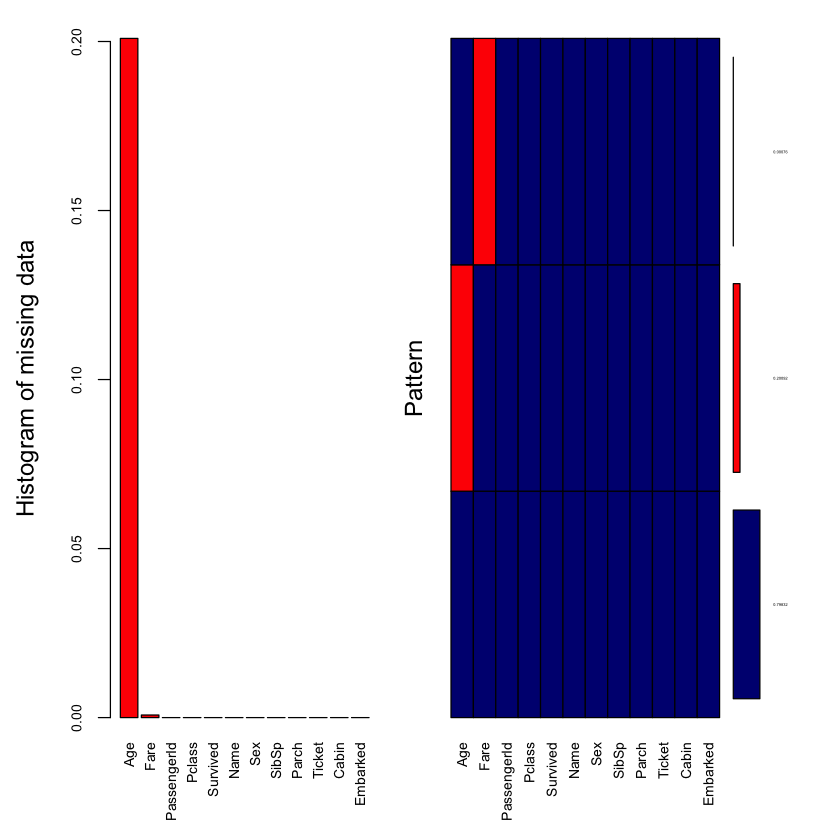

In [73]:
aggr_plot <- aggr(data_titanic, col=c('navyblue','red'), numbers=TRUE, sortVars=TRUE, labels=names(data), cex.numbers=.2, cex.axis=.7, gap=3, ylab=c("Histogram of missing data","Pattern"))

## 2 Feature Engineering: Phase 1
### 2.1 New Feature Variable: "Title"
The feature *"Passenger’s name"* can be broken down into additional meaningful variables which can feed predictions or be used in the creation of additional new variables. For instance, passenger title is contained within the passenger name variable and we can use *surname* to represent families. 

In [74]:
# Grab title from passenger names
data_titanic$Title <- gsub('(.*, )|(\\..*)', '', data_titanic$Name)

# Show title counts by sex
table(data_titanic$Sex, data_titanic$Title)

        
         Capt Col Don Dona  Dr Jonkheer Lady Major Master Miss Mlle Mme  Mr Mrs
  female    0   0   0    1   1        0    1     0      0  260    2   1   0 197
  male      1   4   1    0   7        1    0     2     61    0    0   0 757   0
        
          Ms Rev Sir the Countess
  female   2   0   0            1
  male     0   8   1            0

In [75]:
# Titles with very low cell counts to be combined to "rare" level
rare_title <- c('Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer')

# Also reassign mlle, ms, and mme accordingly
data_titanic$Title[data_titanic$Title == 'Mlle']        <- 'Miss' 
data_titanic$Title[data_titanic$Title == 'Ms']          <- 'Miss'
data_titanic$Title[data_titanic$Title == 'Mme']         <- 'Mrs' 
data_titanic$Title[data_titanic$Title %in% rare_title]  <- 'Rare Title'

# Show title counts by sex again
table(data_titanic$Sex, data_titanic$Title)

        
         Master Miss  Mr Mrs Rare Title
  female      0  264   0 198          4
  male       61    0 757   0         25

In [76]:
# Finally, grab surname from passenger name
data_titanic$Surname <- sapply(data_titanic$Name,  
                      function(x) strsplit(x, split = '[,.]')[[1]][1])

In [77]:
cat(paste( 'Titanic\'s', nrow(data_titanic), 'passengers had', nlevels(factor(data_titanic$Surname)), 'unique surnames.'))

Titanic's 1309 passengers had 875 unique surnames.

### 2.2 New Feature Variables: "Family", "Fsize", "FsizeD"
Make a family size variable based on number of siblings/spouse(s) (maybe someone has more than one spouse?) and number of children/parents.

In [78]:
# Create a family size variable including the passenger themselves
data_titanic$Fsize <- data_titanic$SibSp + data_titanic$Parch + 1

# Create a family variable 
data_titanic$Family <- paste(data_titanic$Surname, data_titanic$Fsize, sep='_')

What does our family size variable look like? 

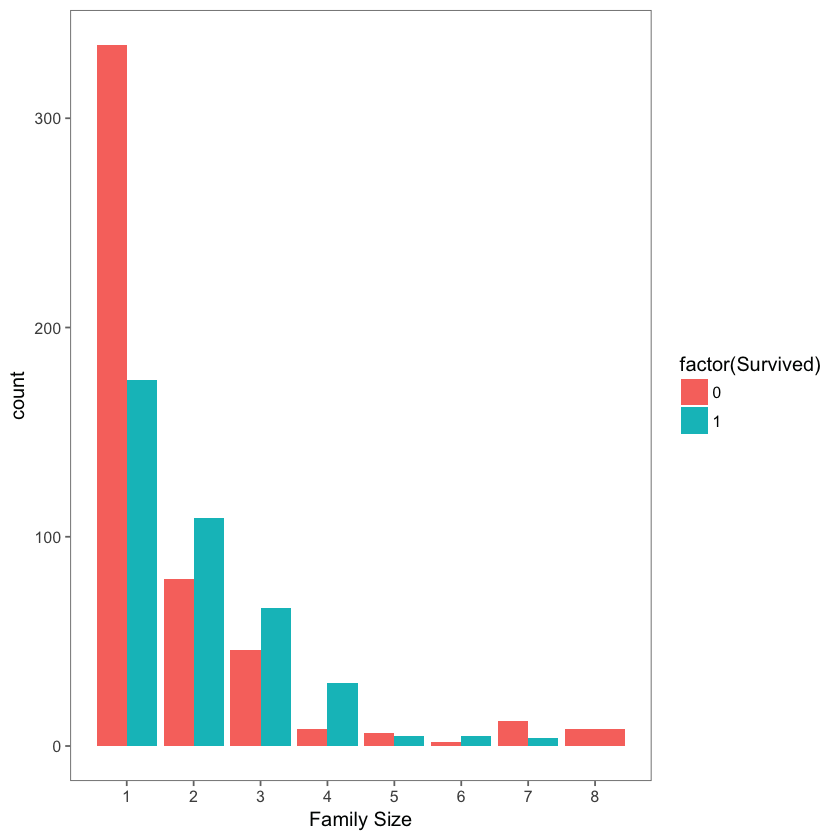

In [79]:
# Use ggplot2 to visualize the relationship between family size & survival
ggplot(data_titanic[1:891,], aes(x = Fsize, fill = factor(Survived))) +
  geom_bar(stat='count', position='dodge') +
  scale_x_continuous(breaks=c(1:11)) +
  labs(x = 'Family Size') +
  theme_few()

We can see that there’s a survival penalty to singletons and those with family sizes above 4. We can collapse this variable into three levels which will be helpful since there are comparatively fewer large families. Let’s create a **discretized family size** variable.

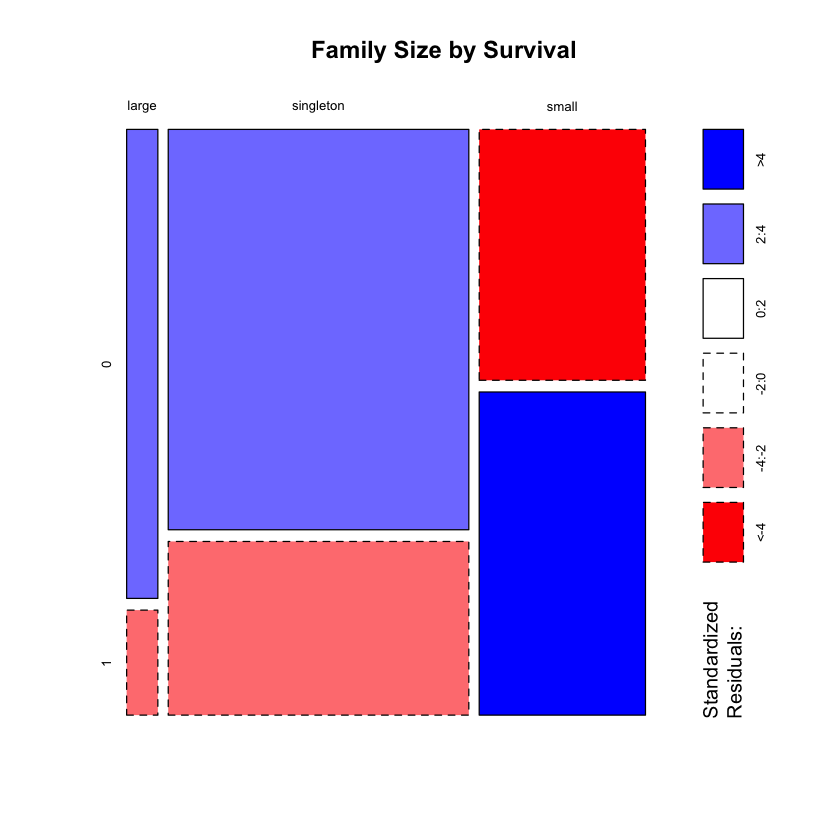

In [80]:
# Discretize family size
data_titanic$FsizeD[data_titanic$Fsize == 1] <- 'singleton'
data_titanic$FsizeD[data_titanic$Fsize < 5 & data_titanic$Fsize > 1] <- 'small'
data_titanic$FsizeD[data_titanic$Fsize > 4] <- 'large'

# Show family size by survival using a mosaic plot
mosaicplot(table(data_titanic$FsizeD, data_titanic$Survived), main='Family Size by Survival', shade=TRUE)

The mosaic plot shows that we preserve our rule that there’s a survival penalty among singletons and large families, but a benefit for passengers in small families. I want to do something further with our age variable, but 263 rows have missing age values, so we will have to wait until after we address missingness.

### 2.3 New Feature Variable: "Deck"
There’s probably some potentially useful information in the passenger cabin variable including about their deck.

In [81]:
# This variable appears to have a lot of missing values
table(data_titanic$Cabin[1:28])


            A23     A36     B35     B49      B5 B58 B60    C101    C148 C22 C26 
      5       1       1       1       2       1       2       1       1       4 
     C6 C62 C64     C97     D15     D35      D7     E12 
      1       2       1       1       2       1       1 

In [82]:
# The first character is the deck. For example:
strsplit(data_titanic$Cabin[2], NULL)[[1]]

[1] "C" "2" "2" " " "C" "2" "6"

In [83]:
# Create a Deck variable. Get passenger deck A - F:
data_titanic$Deck<-factor(sapply(data_titanic$Cabin, function(x) strsplit(x, NULL)[[1]][1]))
table(data_titanic$Deck)


 A  B  C  D  E  F  G  T 
22 65 94 46 41 21  5  1 

There’s more that likely could be done here including looking into cabins with multiple rooms listed (e.g., row 28: “C23 C25 C27”), but given the sparseness of the column we’ll stop here.

In [84]:
head(data_titanic, 3)

PassengerId,Pclass,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,Fsize,Family,FsizeD,Deck
1,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,Miss,Allen,1,Allen_1,singleton,B
2,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,Master,Allison,4,Allison_4,small,C
3,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,Miss,Allison,4,Allison_4,small,C


## 3 Feature Engineering: Phase 2

#### Missing Data

Missing data can be a not so trivial problem when analysing a dataset and accounting for it is usually not so straightforward either.

If the amount of missing data is very small relatively to the size of the dataset, then leaving out the few samples with missing features may be the best strategy in order not to bias the analysis, however leaving out available datapoints deprives the data of some amount of information and depending on the situation you face, you may want to look for other fixes before wiping out potentially useful datapoints from your dataset.

While some quick fixes such as mean-substitution may be fine in some cases, such simple approaches usually introduce bias into the data, for instance, applying mean substitution leaves the mean unchanged (which is desirable) but decreases variance, which may be undesirable.

### 3.1 Missing Feature Data: "Fare"
We will infer their values for embarkment based on present data that we can imagine may be relevant: passenger class and fare.

In [85]:
# Show number of missing Embarked values
sum(is.na(data_titanic$Embarked))

[1] 0

In [86]:
# Show number of missing Fare values
sum(is.na(data_titanic$Fare))

[1] 1

In [87]:
# Show number of missing Embarked values
passengers_missing_fare <- which(is.na(data_titanic$Fare), arr.ind=TRUE)
print(passengers_missing_fare)
data_titanic[which(data_titanic$PassengerId == passengers_missing_fare), ]

[1] 1226


,PassengerId,Pclass,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,Fsize,Family,FsizeD,Deck
1226,1226,3,0,"Storey, Mr. Thomas",male,60.5,0,0,3701,NA,,S,Mr,Storey,1,Storey_1,singleton,NA


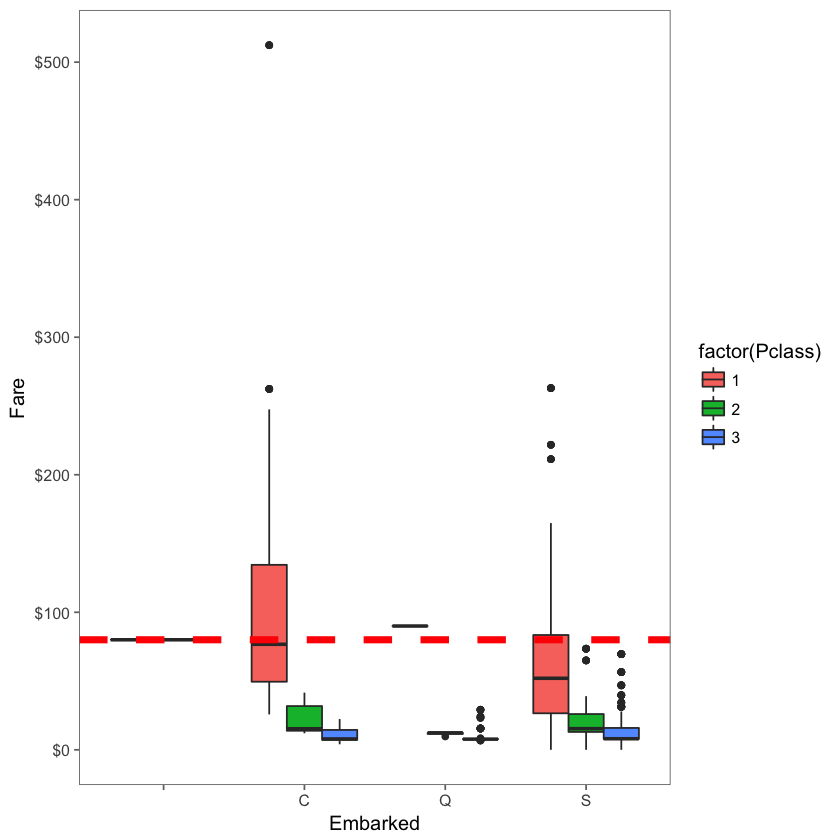

In [88]:
embark_fare <- data_titanic %>%
  filter(PassengerId != 1226)

# Use ggplot2 to visualize embarkment, passenger class, & median fare
ggplot(embark_fare, aes(x = Embarked, y = Fare, fill = factor(Pclass))) +
  geom_boxplot() +
  geom_hline(aes(yintercept=80), 
    colour='red', linetype='dashed', lwd=2) +
  scale_y_continuous(labels=dollar_format()) +
  theme_few()

The median fare for a first class passenger departing from Charbourg (‘C’) coincides nicely with the $80 paid by our embarkment-deficient passengers. We can safely replace the NA values with ‘C’.

Visualize Fares among all third class passenger who departed from Southampton (‘S’).

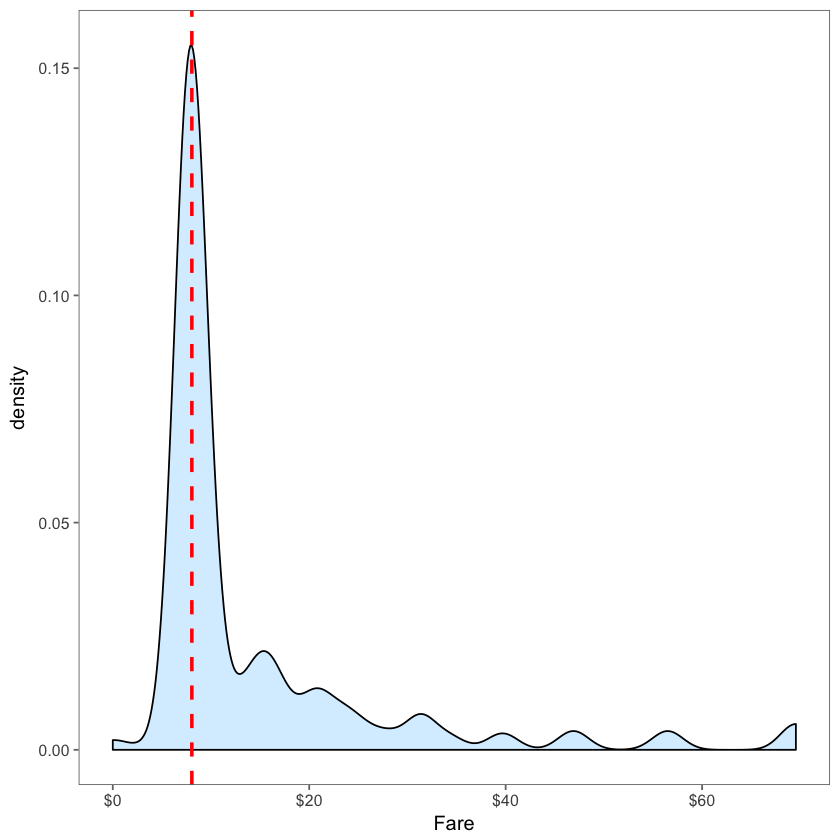

In [89]:
ggplot(embark_fare[embark_fare$Pclass == '3' & embark_fare$Embarked == 'S', ], 
  aes(x = Fare)) +
  geom_density(fill = '#99d6ff', alpha=0.4) + 
  geom_vline(aes(xintercept=median(Fare, na.rm=T)),
    colour='red', linetype='dashed', lwd=1) +
  scale_x_continuous(labels=dollar_format()) +
  theme_few()

In [90]:
missing_fare <- median(data_titanic[data_titanic$Pclass == '3' & data_titanic$Embarked == 'S', ]$Fare, na.rm = TRUE)
print(missing_fare)

[1] 8.05


From this visualization, it seems quite reasonable to replace the NA Fare value with median for their class and embarkment which is $8.05.

In [91]:
# Replace missing fare value with median fare for class/embarkment
data_titanic$Fare[1226] <- missing_fare
data_titanic[1226,]

,PassengerId,Pclass,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,Fsize,Family,FsizeD,Deck
1226,1226,3,0,"Storey, Mr. Thomas",male,60.5,0,0,3701,8.05,,S,Mr,Storey,1,Storey_1,singleton,NA


### 3.2 Missing Feature Data: "Age"

Missing Age values in our data. We are going to get a bit more fancy in imputing missing age values. 

In [92]:
# Show number of missing Age values
sum(is.na(data_titanic$Age))

[1] 263

#### Imputing missing data with R; MICE package

The mice package in R, helps you imputing missing values with plausible data values. These plausible values are drawn from a distribution specifically designed for each missing datapoint.

We could definitely use `rpart (recursive partitioning for regression)` to predict missing ages, but going to use the `mice` package for this task.

In [93]:
# Make variables factors into factors
factor_vars <- c('PassengerId','Pclass','Sex','Embarked',
                 'Title','Surname','Family','FsizeD')

data_titanic[factor_vars] <- lapply(data_titanic[factor_vars], function(x) as.factor(x))

# Set a random seed
set.seed(129)

# Perform mice imputation, excluding certain less-than-useful variables:
mice_mod <- mice(data_titanic[, !names(data_titanic) %in% c('PassengerId','Name','Ticket','Cabin','Family','Surname','Survived')], method='rf')
summary(mice_mod)


 iter imp variable
  1   1  Age  Deck
  1   2  Age  Deck
  1   3  Age  Deck
  1   4  Age  Deck
  1   5  Age  Deck
  2   1  Age  Deck
  2   2  Age  Deck
  2   3  Age  Deck
  2   4  Age  Deck
  2   5  Age  Deck
  3   1  Age  Deck
  3   2  Age  Deck
  3   3  Age  Deck
  3   4  Age  Deck
  3   5  Age  Deck
  4   1  Age  Deck
  4   2  Age  Deck
  4   3  Age  Deck
  4   4  Age  Deck
  4   5  Age  Deck
  5   1  Age  Deck
  5   2  Age  Deck
  5   3  Age  Deck
  5   4  Age  Deck
  5   5  Age  Deck
Multiply imputed data set
Call:
mice(data = data_titanic[, !names(data_titanic) %in% c("PassengerId", 
    "Name", "Ticket", "Cabin", "Family", "Surname", "Survived")], 
    method = "rf")
Number of multiple imputations:  5
Missing cells per column:
  Pclass      Sex      Age    SibSp    Parch     Fare Embarked    Title 
       0        0      263        0        0        0        0        0 
   Fsize   FsizeD     Deck 
       0        0     1014 
Imputation methods:
  Pclass      Sex      Age    Sib

In [94]:
# Save the complete output 
mice_output <- complete(mice_mod)

Let’s compare the results we get with the original distribution of passenger ages to ensure that nothing has gone completely awry.

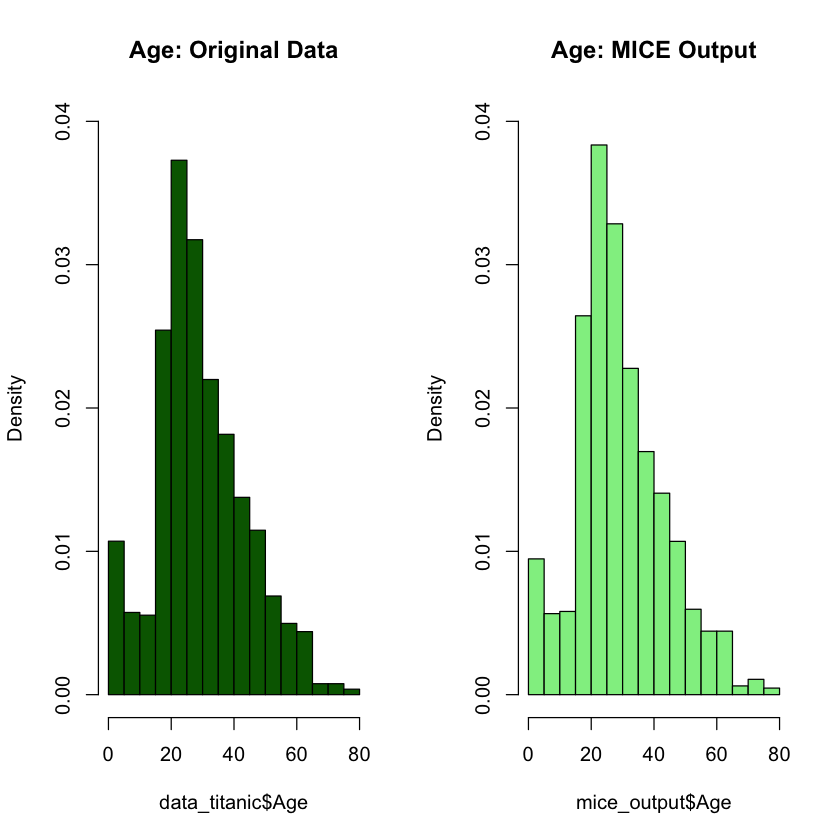

In [95]:
# Plot age distributions
par(mfrow=c(1,2))
hist(data_titanic$Age, freq=F, main='Age: Original Data', 
  col='darkgreen', ylim=c(0,0.04))
hist(mice_output$Age, freq=F, main='Age: MICE Output', 
  col='lightgreen', ylim=c(0,0.04))

#### library "lattice": Lattice Graphs

`densityplot()` presents the density of the imputed data for each imputed dataset is showed in magenta while the density of the observed data is showed in blue. Again, under our previous assumptions we expect the distributions to be similar.

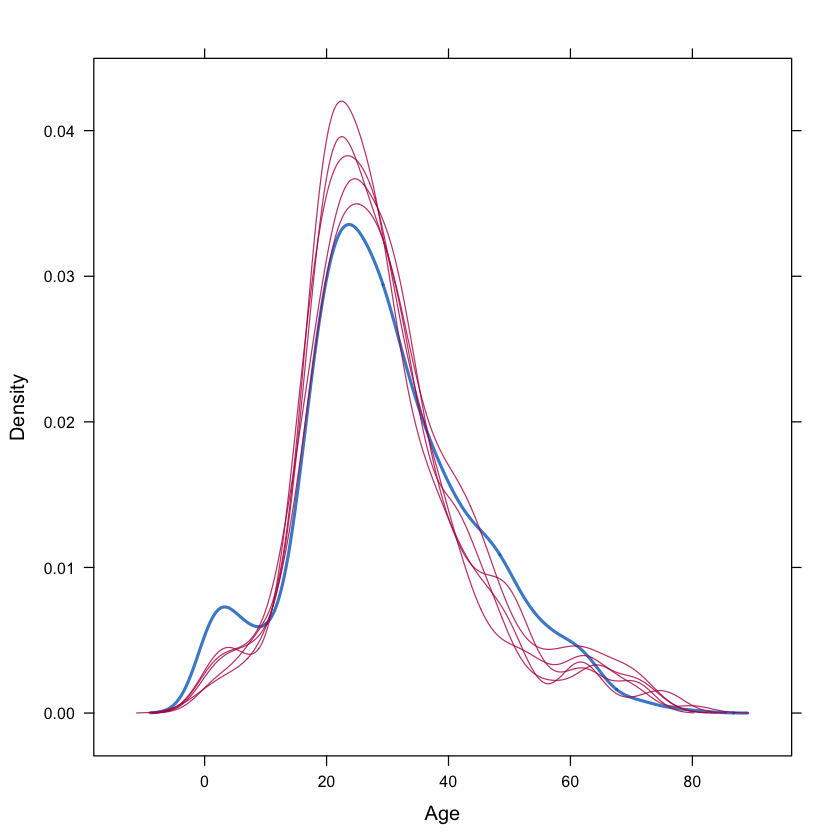

In [99]:
densityplot(mice_mod)

Another useful visual take on the distributions can be obtained using the `stripplot()` function that shows the distributions of the variables as individual points

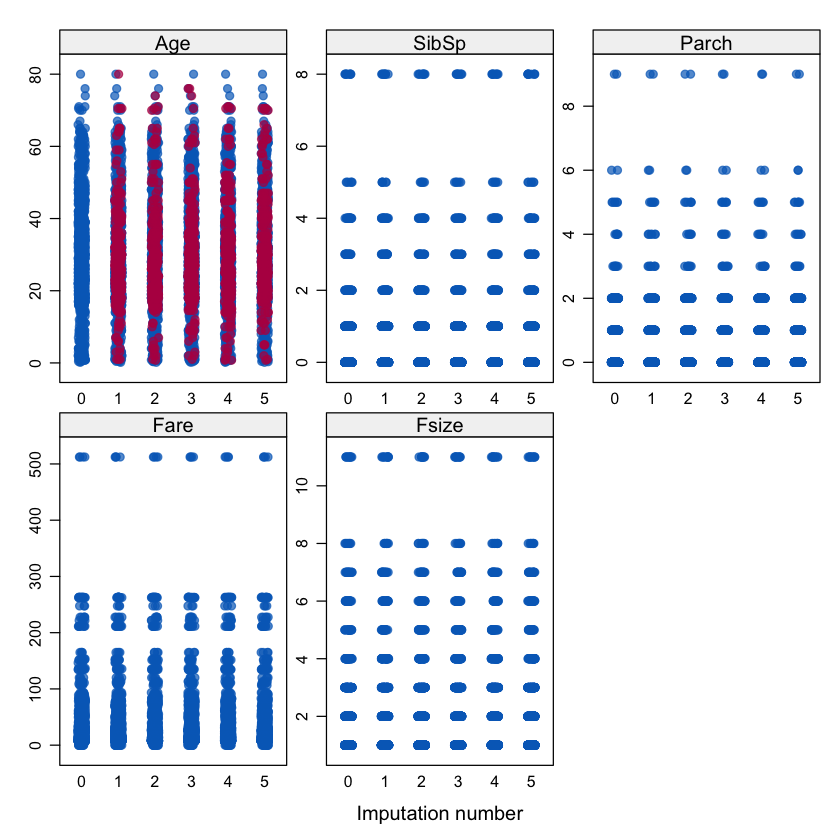

In [100]:
stripplot(mice_mod, pch = 20, cex = 1.2)

Things look good, so let’s replace our age vector in the original data with the output from the mice model.

In [101]:
# Replace Age variable from the mice model.
data_titanic$Age <- mice_output$Age

# Show new number of missing Age values
sum(is.na(data_titanic$Age))

[1] 0

### 3.3 New Feature Variables: "Child", "Mother"

Now that we know everyone’s age, we can create a couple of new age-dependent variables: Child and Mother. A child will simply be someone under 18 years of age and a mother is a passenger who is 1) female, 2) is over 18, 3) has more than 0 children (no kidding!), and 4) does not have the title ‘Miss’.

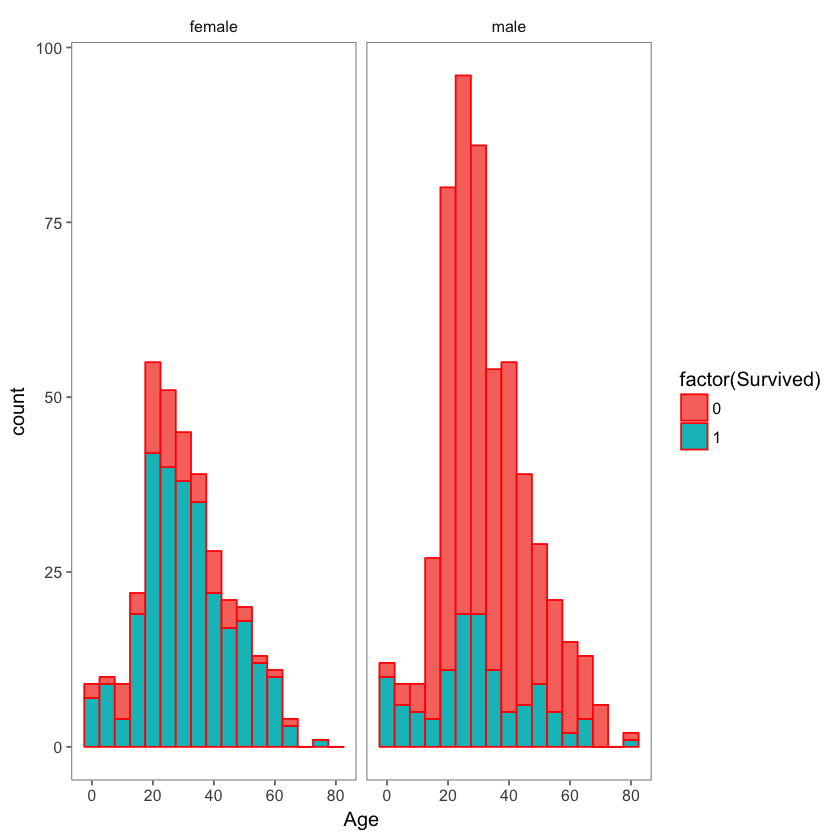

In [102]:
# First we'll look at the relationship between age & survival
ggplot(data_titanic[1:891,], aes(Age, fill = factor(Survived))) + 
  geom_histogram(binwidth=5, col=I("red")) + 
  # Included Sex since we know (a priori) it's a significant predictor
  facet_grid(.~Sex) + 
  theme_few()

In [103]:
# Create the column child, and indicate whether child or adult
data_titanic$Child[data_titanic$Age < 18] <- 'Child'
data_titanic$Child[data_titanic$Age >= 18] <- 'Adult'

# Show counts
table(data_titanic$Child, data_titanic$Survived)

       
          0   1
  Adult 715 407
  Child  94  93

Looks like being a child doesn’t hurt, but it’s not going to necessarily save you either! 

In [104]:
# Adding Mother variable
data_titanic$Mother <- 'Not Mother'
data_titanic$Mother[data_titanic$Sex == 'female' & data_titanic$Parch > 0 & data_titanic$Age > 18 & data_titanic$Title != 'Miss'] <- 'Mother'

# Show counts
table(data_titanic$Mother, data_titanic$Survived)

            
               0   1
  Mother      21  63
  Not Mother 788 437

In [105]:
# Finish by factorizing our two new factor variables
data_titanic$Child  <- factor(data_titanic$Child)
data_titanic$Mother <- factor(data_titanic$Mother)
table(data_titanic$Mother, data_titanic$Child)

            
             Adult Child
  Mother        84     0
  Not Mother  1038   187

### 3.4 Review Feature Engineering Completed

In [106]:
head(data_titanic, 3)

PassengerId,Pclass,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,Fsize,Family,FsizeD,Deck,Child,Mother
1,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,Miss,Allen,1,Allen_1,singleton,B,Adult,Not Mother
2,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,Master,Allison,4,Allison_4,small,C,Child,Not Mother
3,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,Miss,Allison,4,Allison_4,small,C,Child,Not Mother


### 3.5 Using mice for looking at missing data pattern

All of the variables we care about should be taken care of and there should be no missing data.

The `mice` package provides a nice function `md.pattern()` to get a better understanding of the pattern of missing data.

In [107]:
suppressWarnings(md.pattern(data_titanic))

,PassengerId,Pclass,Survived,Sex,Age,SibSp,Parch,Fare,Embarked,Title,⋯,Fsize,Family,FsizeD,Child,Mother,Ticket,Deck,Name,Cabin,
211,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,0,0,2
84,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,0,1,0,0,3
746,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,0,0,0,3
268,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,0,0,0,0,4
,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,352,1014,1309,1309,3984


## 4 Prediction

### 4.1 Split into training & test sets
Our first step is to split the data back into the original test and training sets.

In [41]:
# Split the data back into a train set and a test set
train <- data_titanic[1:891,]
test <- data_titanic[892:1309,]

### 4.2 Training the model
We then build our model using `randomForest` on the training set.

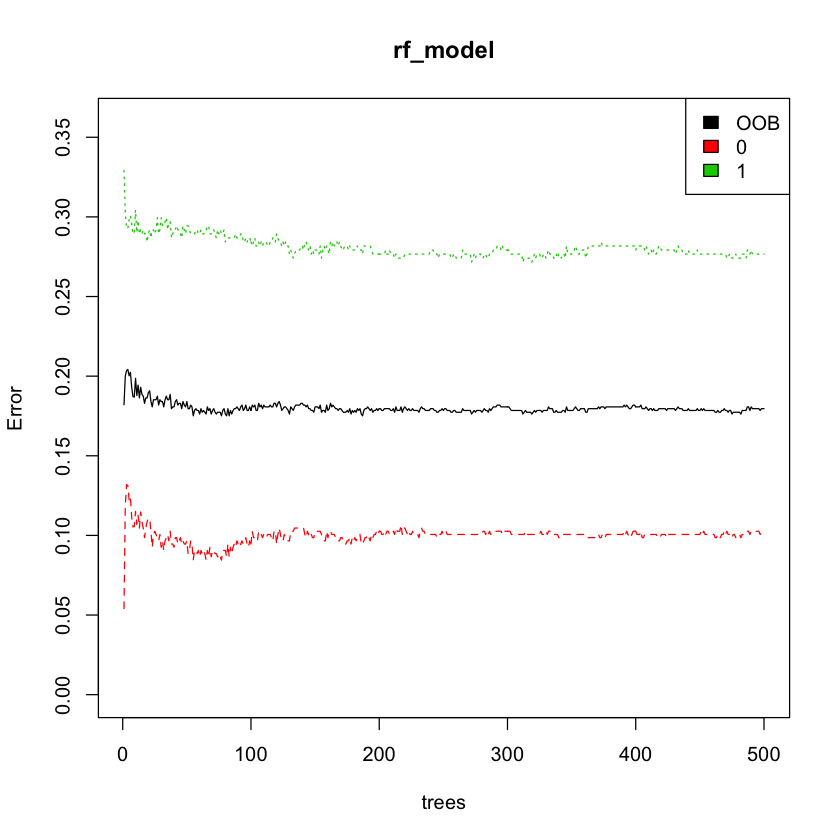

In [42]:
# Set a random seed
set.seed(754)

# Build the model (note: not all possible variables are used)
rf_model <- randomForest(factor(Survived) ~ Pclass + Sex + Age + SibSp + Parch + 
                                            Fare + Embarked + Title + 
                                            FsizeD + Child + Mother,
                                            data = train)

# Show model error
plot(rf_model, ylim=c(0,0.36))
legend('topright', colnames(rf_model$err.rate), col=1:3, fill=1:3)

The black line shows the overall error rate which falls below **20%**. The red and green lines show the error rate for **‘died’** and **‘survived’** respectively. 

We can see that right now we’re much more successful predicting death than we are survival. What does that say about me, I wonder?

### 4.3 Variable importance
Let’s look at relative variable importance by plotting the mean decrease in Gini calculated across all trees.

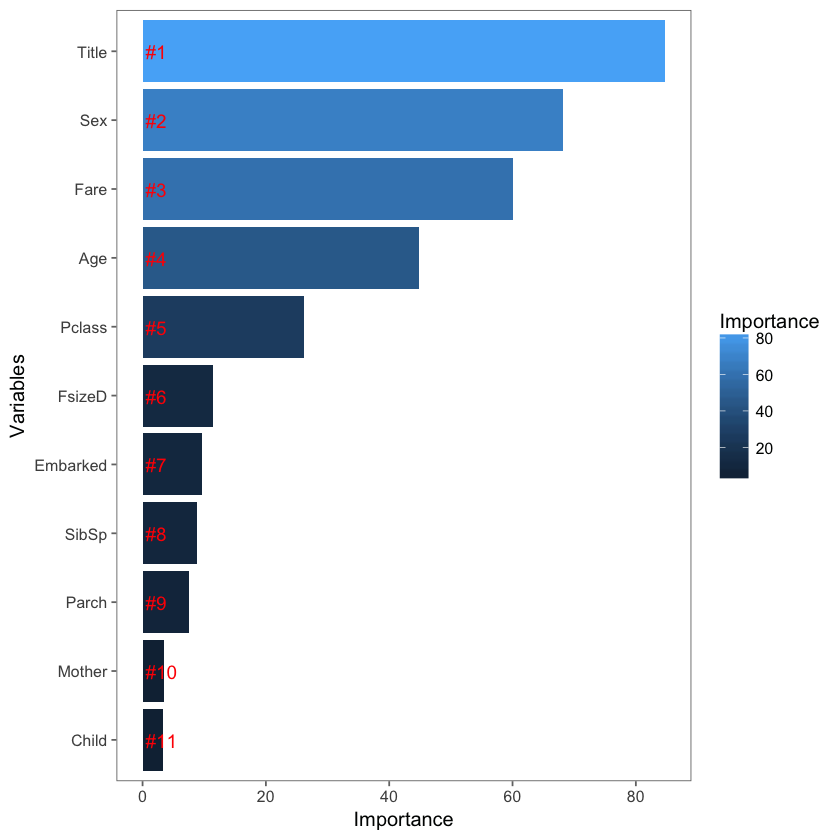

In [43]:
# Get importance
importance    <- importance(rf_model)
varImportance <- data.frame(Variables = row.names(importance), 
                            Importance = round(importance[ ,'MeanDecreaseGini'],2))

# Create a rank variable based on importance
rankImportance <- varImportance %>%
  mutate(Rank = paste0('#',dense_rank(desc(Importance))))

# Use ggplot2 to visualize the relative importance of variables
ggplot(rankImportance, aes(x = reorder(Variables, Importance), 
    y = Importance, fill = Importance)) +
  geom_bar(stat='identity') + 
  geom_text(aes(x = Variables, y = 0.5, label = Rank),
    hjust=0, vjust=0.55, size = 4, colour = 'red') +
  labs(x = 'Variables') +
  coord_flip() + 
  theme_few()

### 4.4 Prediction

In [44]:
test_wo_survived <- test[, !(colnames(data_titanic) %in% c("Survived"))]

# Predict using the test set
prediction <- predict(rf_model, test_wo_survived)

# Save the solution to a dataframe with two columns: PassengerId and Survived (prediction)
solution <- data.frame(PassengerID = test$PassengerId, SurvivedPrediction = prediction, SurvivedActual = test$Survived)

head(solution, 5)

accuracy <- round(nrow(solution[solution$SurvivedPrediction == solution$SurvivedActual,]) / nrow(solution) * 100, 2)

cat(paste( "Model accuracy: ", accuracy, "%"))

,PassengerID,SurvivedPrediction,SurvivedActual
892,892,0,0
893,893,0,0
894,894,0,0
895,895,1,1
896,896,1,1


Model accuracy:  76.08 %

In [49]:
getTree(rf_model, 3, labelVar=TRUE)


left daughter,right daughter,split var,split point,status,prediction
2,3,Title,11.0000,1,NA
4,5,Pclass,3.0000,1,NA
6,7,Embarked,2.0000,1,NA
8,9,Age,24.5000,1,NA
10,11,Parch,1.5000,1,NA
12,13,Title,4.0000,1,NA
14,15,FsizeD,1.0000,1,NA
0,0,NA,0.0000,-1,1
16,17,Fare,32.0896,1,NA
18,19,SibSp,0.5000,1,NA


[Plotting trees from Random Forest models with ggraph](https://www.r-bloggers.com/plotting-trees-from-random-forest-models-with-ggraph/)